## Natural Language Processing

This is a natural language processing project aims to classify the emoji of one given sentence.

Here we use the "Emoji" dataset, each sentence of the dataset corresponds to a emoji. There are total 5 different emojis in the data set.

Our goal is to find the approapriate emoji for a given sentence.

Preparations:
1. Set up a python environment.
2. Install the packages needed in the 'requirement.txt'.

Import libraries

In [ ]:
import numpy as np
import nlp_proj_utils as utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


np.random.seed(1)

Load the data set

In [29]:
train_x, test_x, train_y, test_y = utils.load_emoji()
train_y.shape
train_y.reshape(-1).shape

(132,)

Download and load word embeddings

In [38]:
word_to_index, word_to_vec_map = utils.load_glove_vecs()


data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


dict

In [21]:
# Randomly print 10 samples
for i in range(10):
    index=np.random.randint(train_x.size)
    print(train_x[index], utils.label_to_emoji(train_y[index]))

he is so cute ❤️
he did an amazing job 😄
great job 😄
you got a down grade 😞
he is the best player ⚾
Miss you so much ❤️
candy is life  😄
Congratulations 😄
I love dogs ❤️
I am hungry 🍴


Define a function to turn a ndarray to a one-hot-matrix

In [32]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]    ## reshape to one row       .reshape(-1,1) : to one column
    return Y

In [34]:
train_y_oh = convert_to_one_hot(train_y, 5)
test_y_oh = convert_to_one_hot(test_y, 5)

There is a vector in the pretrained word-embeddings corresponding to each word.
For a sentence, we extract the corresponding vectors of each word in it and take a average.

In [39]:
def sentence_to_avg(sentence, word_to_vec_map):
    import numpy as np

    # Convert a sentence string into the average of word vector (dim = 50)
    words = sentence.lower().split()

    avg = np.zeros((50,))
    cnt = 0
    for w in words:
        avg += word_to_vec_map.get(w, np.zeros((50,)))   ##if w does not exist, return np.zeros
        cnt += 1
    avg = avg / cnt

    return avg

In [40]:
train_x = np.array(
    [sentence_to_avg(x, word_to_vec_map) for x in train_x])

test_x = np.array(
    [sentence_to_avg(x, word_to_vec_map) for x in test_x])

Build a two-layer nueral network model

In [41]:
def build_nn_model(input_dim, layers, output_dim):
    X = Input(shape=(input_dim,))
    H = X
    for layer in layers:
        H = Dense(layer, activation='relu')(H)
    activation_func = 'softmax' if output_dim > 1 else 'sigmoid'
    
    Y = Dense(output_dim, activation=activation_func)(H)
    return Model(inputs=X, outputs=Y)

In [42]:
emoji_model = build_nn_model(
    input_dim=50, 
    layers=[50], 
    output_dim=5)

emoji_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
emoji_history = emoji_model.fit(
    train_x, 
    train_y_oh, 
    epochs=500, 
    shuffle=True, 
    validation_data=(test_x, test_y_oh), )

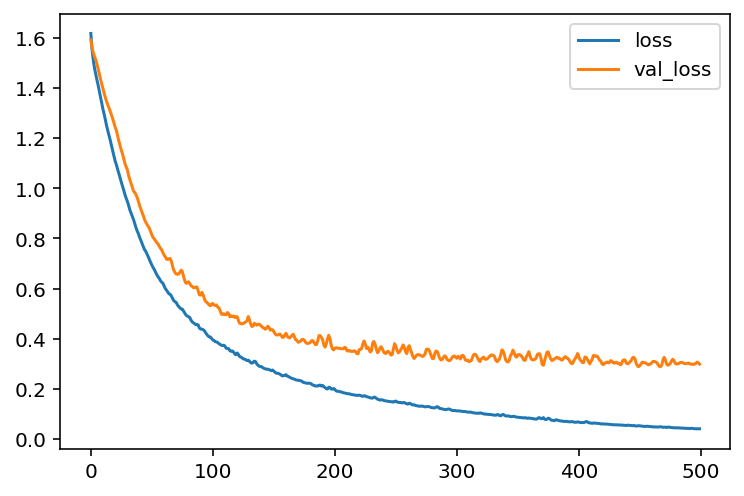

In [44]:
utils.plot_history(emoji_history, ['loss', 'val_loss'])

In [45]:
emoji_model.evaluate(train_x, train_y_oh)
emoji_model.evaluate(test_x, test_y_oh)

56/56 [==============================] - 0s 67us/sample - loss: 0.2988 - acc: 0.8393


[0.29876862253461567, 0.83928573]

### To improve the performance, add a word-embedding layer and build a LSTM model.

Convert training/testing features into index list

In [50]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    for i in range(m):
        sentence_words = X[i].lower().split()
        j = 0
        for w in sentence_words:
            X_indices[i, j] = word_to_index[w]
            j = j + 1
    return X_indices

Reload the data set

In [72]:
train_x, test_x, train_y, test_y = utils.load_emoji()

In [73]:
maxlen = max([len(x.split()) for x in train_x])

In [74]:
train_x =sentences_to_indices(train_x, word_to_index, maxlen)
test_x = sentences_to_indices(test_x, word_to_index, maxlen)
train_y = convert_to_one_hot(train_y, C = 5)
test_y = convert_to_one_hot(test_y, C = 5)

In [66]:
def pretrained_embedding_layer(word_to_index, word_to_vec_map):
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1  
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    return Embedding(
        input_dim=vocab_len, 
        output_dim=emb_dim, 
        trainable=False,  # Indicating this is a pre-trained embedding 
        weights=[emb_matrix])

In [67]:
def build_emoji_model(input_dim, word_to_index, word_to_vec_map):
    
    # Input layer
    sentence_indices = Input(shape=(input_dim,), dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_index, word_to_vec_map)
    embeddings = embedding_layer(sentence_indices)   
    
    # 2-layer LSTM
    X = LSTM(128, return_sequences=True, recurrent_dropout=0.5)(embeddings)  # N->N RNN
    X = Dropout(rate=0.8)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X)  # N -> 1 RNN
    X = Dropout(rate=0.8)(X)
    X = Dense(5, activation='softmax')(X)
    
    # Create and return model
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [68]:
emoji_model = build_emoji_model(
    maxlen, 
    word_to_index, 
    word_to_vec_map)

emoji_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645 

In [69]:
emoji_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [ ]:
history = emoji_model.fit(
    train_x, 
    train_y, 
    epochs = 100,  
    shuffle=True,
    validation_data=[test_x, test_y]
)

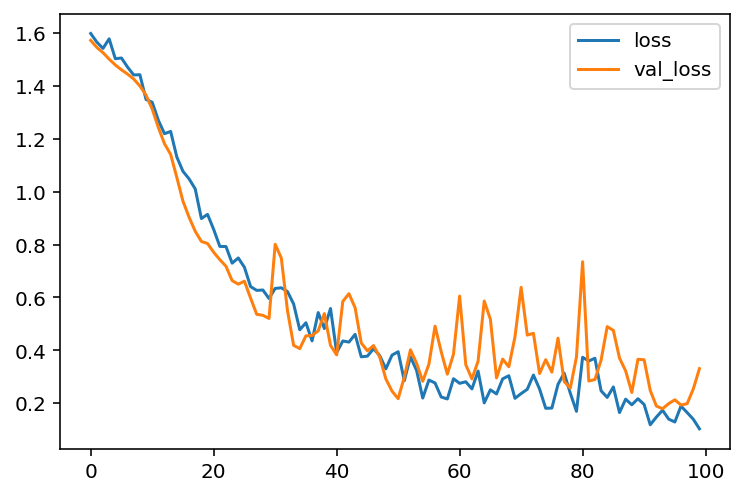

In [76]:
utils.plot_history(history, ['loss', 'val_loss'])

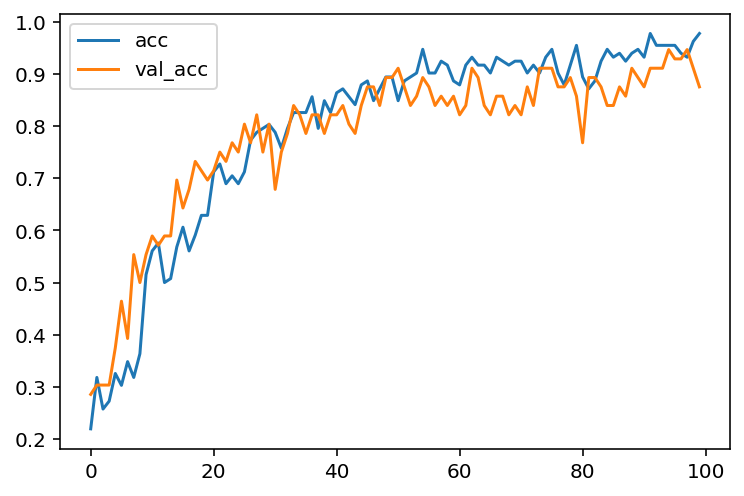

In [77]:
utils.plot_history(history, ['acc', 'val_acc'])

In [78]:
emoji_model.evaluate(train_x, train_y)
emoji_model.evaluate(test_x, test_y)

56/56 [==============================] - 0s 338us/sample - loss: 0.3307 - acc: 0.8750


[0.33072158907141, 0.875]